# **Enzyme design with RF Diffusion 2**
The purpose of this notebook is to give an example of how to run RFD2 for enzyme/small molecule binder design starting with just the 'tip atoms' of your motif residues.

Generating theozymes, correctly configuring the inputs, and choosing which parameters to use at inference.

# I. Download and Install RFD2

In [1]:
import sys, os
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download software and weights - only run once!

##

In [3]:
%cd /content/drive/MyDrive/
!git clone https://github.com/RosettaCommons/RFdiffusion2.git rfd2

/content/drive/MyDrive
Cloning into 'rfd2'...
remote: Enumerating objects: 5247, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 5247 (delta 41), reused 40 (delta 31), pack-reused 5182 (from 2)
Receiving objects: 100% (5247/5247), 147.43 MiB | 9.10 MiB/s, done.
Resolving deltas: 100% (2344/2344), done.
Updating files: 100% (5602/5602), done.


In [5]:
%cd /content/drive/MyDrive/rfd2
!python setup.py

/content/drive/MyDrive/rfd2
=== Setting up RFDiffusion environment ===
Mode: DOWNLOAD 

⇣ Downloading: https://files.ipd.uw.edu/pub/rfdiffusion2/model_weights/RFD_173.pt
→ To: rf_diffusion/model_weights/RFD_173.pt
✓ Download complete: rf_diffusion/model_weights/RFD_173.pt

⇣ Downloading: https://files.ipd.uw.edu/pub/rfdiffusion2/model_weights/RFD_140.pt
→ To: rf_diffusion/model_weights/RFD_140.pt
✓ Download complete: rf_diffusion/model_weights/RFD_140.pt

⇣ Downloading: https://files.ipd.uw.edu/pub/rfdiffusion2/third_party_model_weights/ligand_mpnn/s25_r010_t300_p.pt
→ To: rf_diffusion/third_party_model_weights/ligand_mpnn/s25_r010_t300_p.pt
✓ Download complete: rf_diffusion/third_party_model_weights/ligand_mpnn/s25_r010_t300_p.pt

⇣ Downloading: https://files.ipd.uw.edu/pub/rfdiffusion2/third_party_model_weights/ligand_mpnn/s_300756.pt
→ To: rf_diffusion/third_party_model_weights/ligand_mpnn/s_300756.pt
✓ Download complete: rf_diffusion/third_party_model_weights/ligand_mpnn/s_300756.p

## Install with uv pip




In [3]:
%%time
%cd /content/
!uv venv /content/rfd2 --clear --python 3.11 --seed
!uv pip install --python /content/rfd2/bin/python \
  -r /content/drive/MyDrive/rfd2/envs/requirements_cuda121.txt
!uv pip install --python /content/rfd2/bin/python \
  -r /content/drive/MyDrive/rfd2/pyproject.toml
!uv pip install --python /content/rfd2/bin/python \
  openbabel-wheel

/content
Using CPython 3.11.14
Creating virtual environment with seed packages at: rfd2
 + pip==25.3
 + setuptools==80.9.0
 + wheel==0.45.1
Activate with: source rfd2/bin/activate
Using Python 3.11.14 environment at: rfd2
Resolved 165 packages in 5.45s
Prepared 163 packages in 1m 06s
Installed 163 packages in 1.04s
 + absl-py==2.3.1
 + addict==2.4.0
 + annotated-types==0.7.0
 + antlr4-python3-runtime==4.9.3
 + appdirs==1.4.4
 + assertpy==1.1
 + asttokens==3.0.0
 + astunparse==1.6.3
 + biopython==1.83
 + biotite==1.5.0
 + biotraj==1.2.2
 + certifi==2025.10.5
 + cfgv==3.4.0
 + charset-normalizer==3.4.4
 + click==8.3.0
 + cloudpickle==3.1.2
 + colorama==0.4.6
 + colorlog==6.10.1
 + comm==0.2.3
 + compact-json==1.8.1
 + contextlib2==21.6.0
 + contourpy==1.3.3
 + coverage==7.11.0
 + cramjam==2.11.0
 + cycler==0.12.1
 + cython==3.0.0
 + cytoolz==0.12.3
 + debugpy==1.8.5
 + decorator==5.2.1
 + deepdiff==6.3.0
 + dgl==2.4.0+cu121
 + distlib==0.4.0
 + dm-tree==0.1.8
 + docker-pycreds==0.4.0
 + 

In [4]:
os.environ['PYTHONPATH'] += ":/content/drive/MyDrive/rfd2"

The code below is an extremely hacky way to deal with a problem with installation. Make sure the RFD_DIR path points to your RFD2 directory

In [5]:
%%bash
RFD_DIR='/content/drive/MyDrive/rfd2'
FILE='${RFD_DIR}/rf_diffusion/backup_run_inference.py'
RUNFILE='${RFD_DIR}/rf_diffusion/run_inference.py'
if [ ${FILE} ]; then
  echo "fix already implemented"
else
  echo "fix not implemented"
  echo "making backup of run_inference.py > ${RFD_DIR}/rf_diffusion/backup_run_inference.py"
  cp ${RUNFILE} ${FILE}
  sed -i "s|config/inference|/content/drive/MyDrive/rfd2/rf_diffusion/config/inference|g" $RUNFILE
fi

fix already implemented


In [6]:
!pip install Bio
!pip install py3dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.1 MB/s eta 0:00:00


In [7]:
!export USER="colab"
os.environ["USER"] = "colab"

**If RFD2 is installed correctly, you should be able to run this with no errors**

In [8]:
!/content/rfd2/bin/python \
 /content/drive/MyDrive/rfd2/rf_diffusion/run_inference.py --help

DGL backend not selected or invalid.  Assuming PyTorch for now.
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
/content/drive/MyDrive/rfd2/rf2aa/model/Track_module.py:356: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/content/drive/MyDrive/rfd2/rf2aa/model/Track_module.py:448: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
run_inference is powered by Hydra.

== Configuration groups ==
Compose your configuration from those groups (group=option)



== Config ==
Override anything in the config (foo.bar=value)

inference:
  input_pdb: rf_diffusion/test_data/1qys.pdb
  num_designs: 10
  design_startnum: 0


# II. Preparing inputs for RFD2

Importing packages and setting up notebook

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import shlex, json, math, os, random, copy, re, shutil, statistics, string, subprocess, sys
import textwrap, warnings, concurrent.futures, time, multiprocessing, itertools, operator
from pathlib import Path
from datetime import datetime
import py3Dmol
import Bio


In [10]:
######################################################################
### IMPORT PACKAGES & SETUP NOTEBOOK (RUN AT BEGINNING EVERY TIME) ###
######################################################################

project_name     = 'RFd2_tutorial'

### ---- MANDATORY USER SPECIFICATIONS ----
rfd2_dir  = '/content/drive/MyDrive/rfd2' # Cloned GitHub repo directory path

###################################################### AUTO SETUP ######################################################

### ---- STANDARD LIBRARY IMPORTS ----
import shlex, glob, json, math, os, random, copy, re, shutil, statistics, string, subprocess, sys
import textwrap, warnings, concurrent.futures, time, multiprocessing, itertools, operator
from pathlib import Path
from datetime import datetime

### ---- DERIVED PATHS (CHANGE AT USER DISCRETION) ----
working_dir   = f'/content/drive/MyDrive/enzdes_rfd2_tutorial'
git_dir = rfd2_dir
output_dir    = f'{working_dir}/outputs'
theozymes_dir = f'{working_dir}/theozymes'
scripts_dir = f'{working_dir}/scripts'

for p in [working_dir, output_dir, theozymes_dir, scripts_dir]:
    Path(p).mkdir(parents=True, exist_ok=True) # ensure base dirs exist so downstream cells never fail on missing paths

### ---- 3RD PARTY IMPORTS ----
import numpy as np
import pandas as pd

### ---- PRINTS ----
print(f"### PROJECT {project_name} NOTEBOOK SUCCESSFULLY INITIALIZED ON {datetime.now().strftime('%Y-%m-%d AT TIME %H:%M:%S')} ### ")
print(f"\nExample Variables & Paths:")
print(f"   working_dir   = {working_dir}")
print(f"   theozymes_dir = {theozymes_dir}")
print(f"   output_dir    = {output_dir}")

### PROJECT RFd2_tutorial NOTEBOOK SUCCESSFULLY INITIALIZED ON 2025-11-05 AT TIME 12:43:25 ### 

Example Variables & Paths:
   working_dir   = /content/drive/MyDrive/enzdes_rfd2_tutorial
   theozymes_dir = /content/drive/MyDrive/enzdes_rfd2_tutorial/theozymes
   output_dir    = /content/drive/MyDrive/enzdes_rfd2_tutorial/outputs


## Theozyme generation

The PDB 1QJI is a structure of the protein astacin (a Zn protease) bound to a transition state analog. To design a *de novo* enzyme that can catalyze the same reaction, we can take use the catalytic residues from this structure to build a theozyme for RFD2.

Literature identifies five residues that are key for catalysis - three histidines (the Zn binding site), a tyrosine, and a glutamate. Additionally, there is an evolutionarily conserved methionine that is likely important, however it was left out for the simplicity of this tutorial.

In [11]:
view = py3Dmol.view(query='pdb:1qji', width=600, height=400)
view.setStyle({'cartoon': {'color': 'spectrum'}})

view.addStyle({'and': [
    {'resn': ['TYR','GLU','HIS','MET']}
]}, {'stick': {}})
# Sticks for ligands (anything that’s not a standard residue)
view.addStyle({'hetflag': True}, {'stick': {'colorscheme': 'greenCarbon'}})
view.addStyle({'resn': 'ZN'}, {'sphere': {'color': 'silver', 'radius': 1.0}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
pdb_path = f'{working_dir}/theozymes/1qji_theozyme_HEHHMY.pdb'
with open(pdb_path, 'r') as f:
    pdb_data = f.read()

view = py3Dmol.view(width=600, height=400)
view.addModel(pdb_data, 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.addStyle({'and': [
    {'resn': ['ALA','VAL','LEU','ILE','PHE','TYR','TRP','SER','THR','ASN','GLN','ASP','GLU','LYS','ARG','HIS','CYS','MET','PRO','GLY']}
]}, {'stick': {}})

# Sticks for ligands (anything that’s not a standard residue)
view.addStyle({'hetflag': True}, {'stick': {'colorscheme': 'greenCarbon'}})
view.addStyle({'atom': 'ZN'}, {'sphere': {'color': 'silver', 'radius': 1.0}})

view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## ORI tokens

### What are ORI tokens?

**ORI tokens tell RFD2 where the generated structure should be "centered" around.**

RFD2 reads the ORI token from the input pdb
Here is an example of what an ORI token line looks like:

`HETATM  129  ORI ORI X   2      16.723  25.532  20.642  1.00  1.00          X`


Generally, we will want this to be close to our ligand.

It is good to sample different locations for the ORI token

I have included a script that will generate a sphere of ori tokens in a given radius around a set of coordinates

### Generating ORI tokens

In [13]:
############################
### ORI TOKEN GENERATION ###
############################

### INPUT PARAMETERS ###
input_pdb = f'{theozymes_dir}/1qji_theozyme_HEHHMY.pdb'
theo_outdir = f'{theozymes_dir}/original_ORI_tokens'
radius = 2
num_ORI = 10  # Number of ORI tokens to generate.
initial_ORI_coord = '16.723445892333984 25.53151512145996 20.642473220825195'


### OPTIONAL FLAGS TO ADD ###
homogeneous_sampling = True  # Set to False for random sampling | Would NOT recommend RANDOM SAMPLING
homogeneous_sampling_surface_only = False # Cannot be True if homogenous sampling is False.

### CONSTANTS ###
script = f"{scripts_dir}/enumerate_ORI_homogeneously_or_randomly_in_sphere.py"

### GENERATE COMMAND ###
command = (
    f"python {script} "
    f"--input_pdb {input_pdb} "
    f"--output_dir {theo_outdir} "
    f"--radius {radius} "
    f"--sampling_size {num_ORI} "
    f'--initial_ORI_coord "{initial_ORI_coord}" '
)

if not homogeneous_sampling:
    command += "--random "
if homogeneous_sampling_surface_only:
    command += "--homogenous_distribution_on_sphere_surface_only "

### PRINT COMMAND ###
print(command)

python /content/drive/MyDrive/enzdes_rfd2_tutorial/scripts/enumerate_ORI_homogeneously_or_randomly_in_sphere.py --input_pdb /content/drive/MyDrive/enzdes_rfd2_tutorial/theozymes/1qji_theozyme_HEHHMY.pdb --output_dir /content/drive/MyDrive/enzdes_rfd2_tutorial/theozymes/original_ORI_tokens --radius 2 --sampling_size 10 --initial_ORI_coord "16.723445892333984 25.53151512145996 20.642473220825195" 


In [14]:
#copy, paste, and run command here
!python /content/drive/MyDrive/enzdes_rfd2_tutorial/scripts/enumerate_ORI_homogeneously_or_randomly_in_sphere.py --input_pdb /content/drive/MyDrive/enzdes_rfd2_tutorial/theozymes/1qji_theozyme_HEHHMY.pdb --output_dir /content/drive/MyDrive/enzdes_rfd2_tutorial/theozymes/original_ORI_tokens --radius 2 --sampling_size 10 --initial_ORI_coord "16.723445892333984 25.53151512145996 20.642473220825195"



/usr/local/lib/python3.12/dist-packages/Bio/PDB/Atom.py:237: PDBConstructionWarning: Could not assign element 'ORI' for Atom (name=ORI) with given element 'ORI'
  warnings.warn(msg, PDBConstructionWarning)
### Recommended Sampling Size ###
For optimal coverage, use a sampling size of approximately 16.
### Sampling Information ###
Input Radius: 2.0
Requested Sampling Size: 10
Adjusted Sampling Size (including center point): 17
Number of Layers: 2
Layer Radii: [1. 2.]
Points Per Layer: [4, 12]
###########################
### Rotation and Distance Information ###
Layer 1:
  Rotation Angle: 137.50 degrees
  Avg Intra-Layer Distance: 1.6163 units
  Avg Inter-Layer Distance to Layer 2: 1.2122 units
Layer 2:
  Rotation Angle: 275.00 degrees
  Avg Intra-Layer Distance: 2.8633 units
  Avg Inter-Layer Distance to Layer 1: 2.6247 units
###########################################
Processed ORI atom positioned to /content/drive/MyDrive/enzdes_rfd2_tutorial/theozymes/original_ORI_tokens/1qji_theozym

## Generating yaml files

RFD2 takes yaml files as an input. A common way to run RFD2 is as follows:

run_inference.py --config-dir=CONFIG_DIR --config-name=CONFIG_NAME

An example of the contents of a .yaml file is shown below:

```
guidepost_bonds: True

inference:
  align_motif: False
  ckpt_path: /content/drive/MyDrive/rfd2/rf_diffusion/model_weights/RFD_140.pt
  num_designs: 10
  output_prefix: /content/drive/MyDrive/enzdes_rfd2_tutorial/outputs/rfd2_tutorial_run//1qji_theozyme_HEHHMY_ORI_01_LENGTH_120-160_tutorial_t1
  input_pdb: /content/drive/MyDrive/enzdes_rfd2_tutorial/theozymes/original_ORI_tokens/1qji_theozyme_HEHHMY_ORI_01.pdb
  contig_as_guidepost: True
  guidepost_xyz_as_design: True
  flexible_ligand: False
  deterministic: False
  ligand: QA0
  idealize_sidechain_outputs: True
  radius: 10
  write_trajectory: False
  write_trb: True
  center_motif: True

contigmap:
  contigs: ['120-160,A92-92,A93-93,A96-96,A102-102,A149-149']
  length: '120-160'
  contig_atoms: '{"A92": "NE2,CD2,CG,CB,ND1,CE1", "A96": "NE2,CD2,CG,CB,ND1,CE1", "A102": "NE2,CD2,CG,CB,ND1,CE1", "A149": "OH,CZ,CE2,CD2,CG,CD1,CE1,CB", "A93": "OE1,OE2,CD,CG,CB"}'

diffuser:
  T: 50
```

**In the next few cells, we will build this .yaml file and use it in an RFD2 run**

Below we will define which atoms from the theozyme residues we will use as an input

In [17]:
#####################################################################
### CELL TO HELP GENERATE THE CONTIG ATOMS DEFS FOR THE NEXT CELL ###
#####################################################################

### SPECIFY ATOMS FOR FIXED RESIDUES ###
ligand = 'QA0'
contig_residues = "A92-92,A93-93,A96-96,A102-102,A149-149"
residue_atoms_map = {
    "A92":  ["NE2", "CD2", "CG", "CB", "ND1", "CE1"], # HIS
    "A96":  ["NE2", "CD2", "CG", "CB", "ND1", "CE1"], # HIS
    "A102": ["NE2", "CD2", "CG", "CB", "ND1", "CE1"], # HIS
    "A149": ["OH","CZ","CE2","CD2","CG","CD1","CE1","CB"], # TYR
    "A93": ["OE1", "OE2", "CD", "CG", "CB"] # GLU | OPTIONALLY REMOVE CB
}


### BUILD IT ###
atom_str_map = {res: ",".join(atoms) for res, atoms in residue_atoms_map.items()}
contig_atoms_defs = json.dumps(atom_str_map)

### PRINT ###
print(contig_atoms_defs)

{"A92": "NE2,CD2,CG,CB,ND1,CE1", "A96": "NE2,CD2,CG,CB,ND1,CE1", "A102": "NE2,CD2,CG,CB,ND1,CE1", "A149": "OH,CZ,CE2,CD2,CG,CD1,CE1,CB", "A93": "OE1,OE2,CD,CG,CB"}


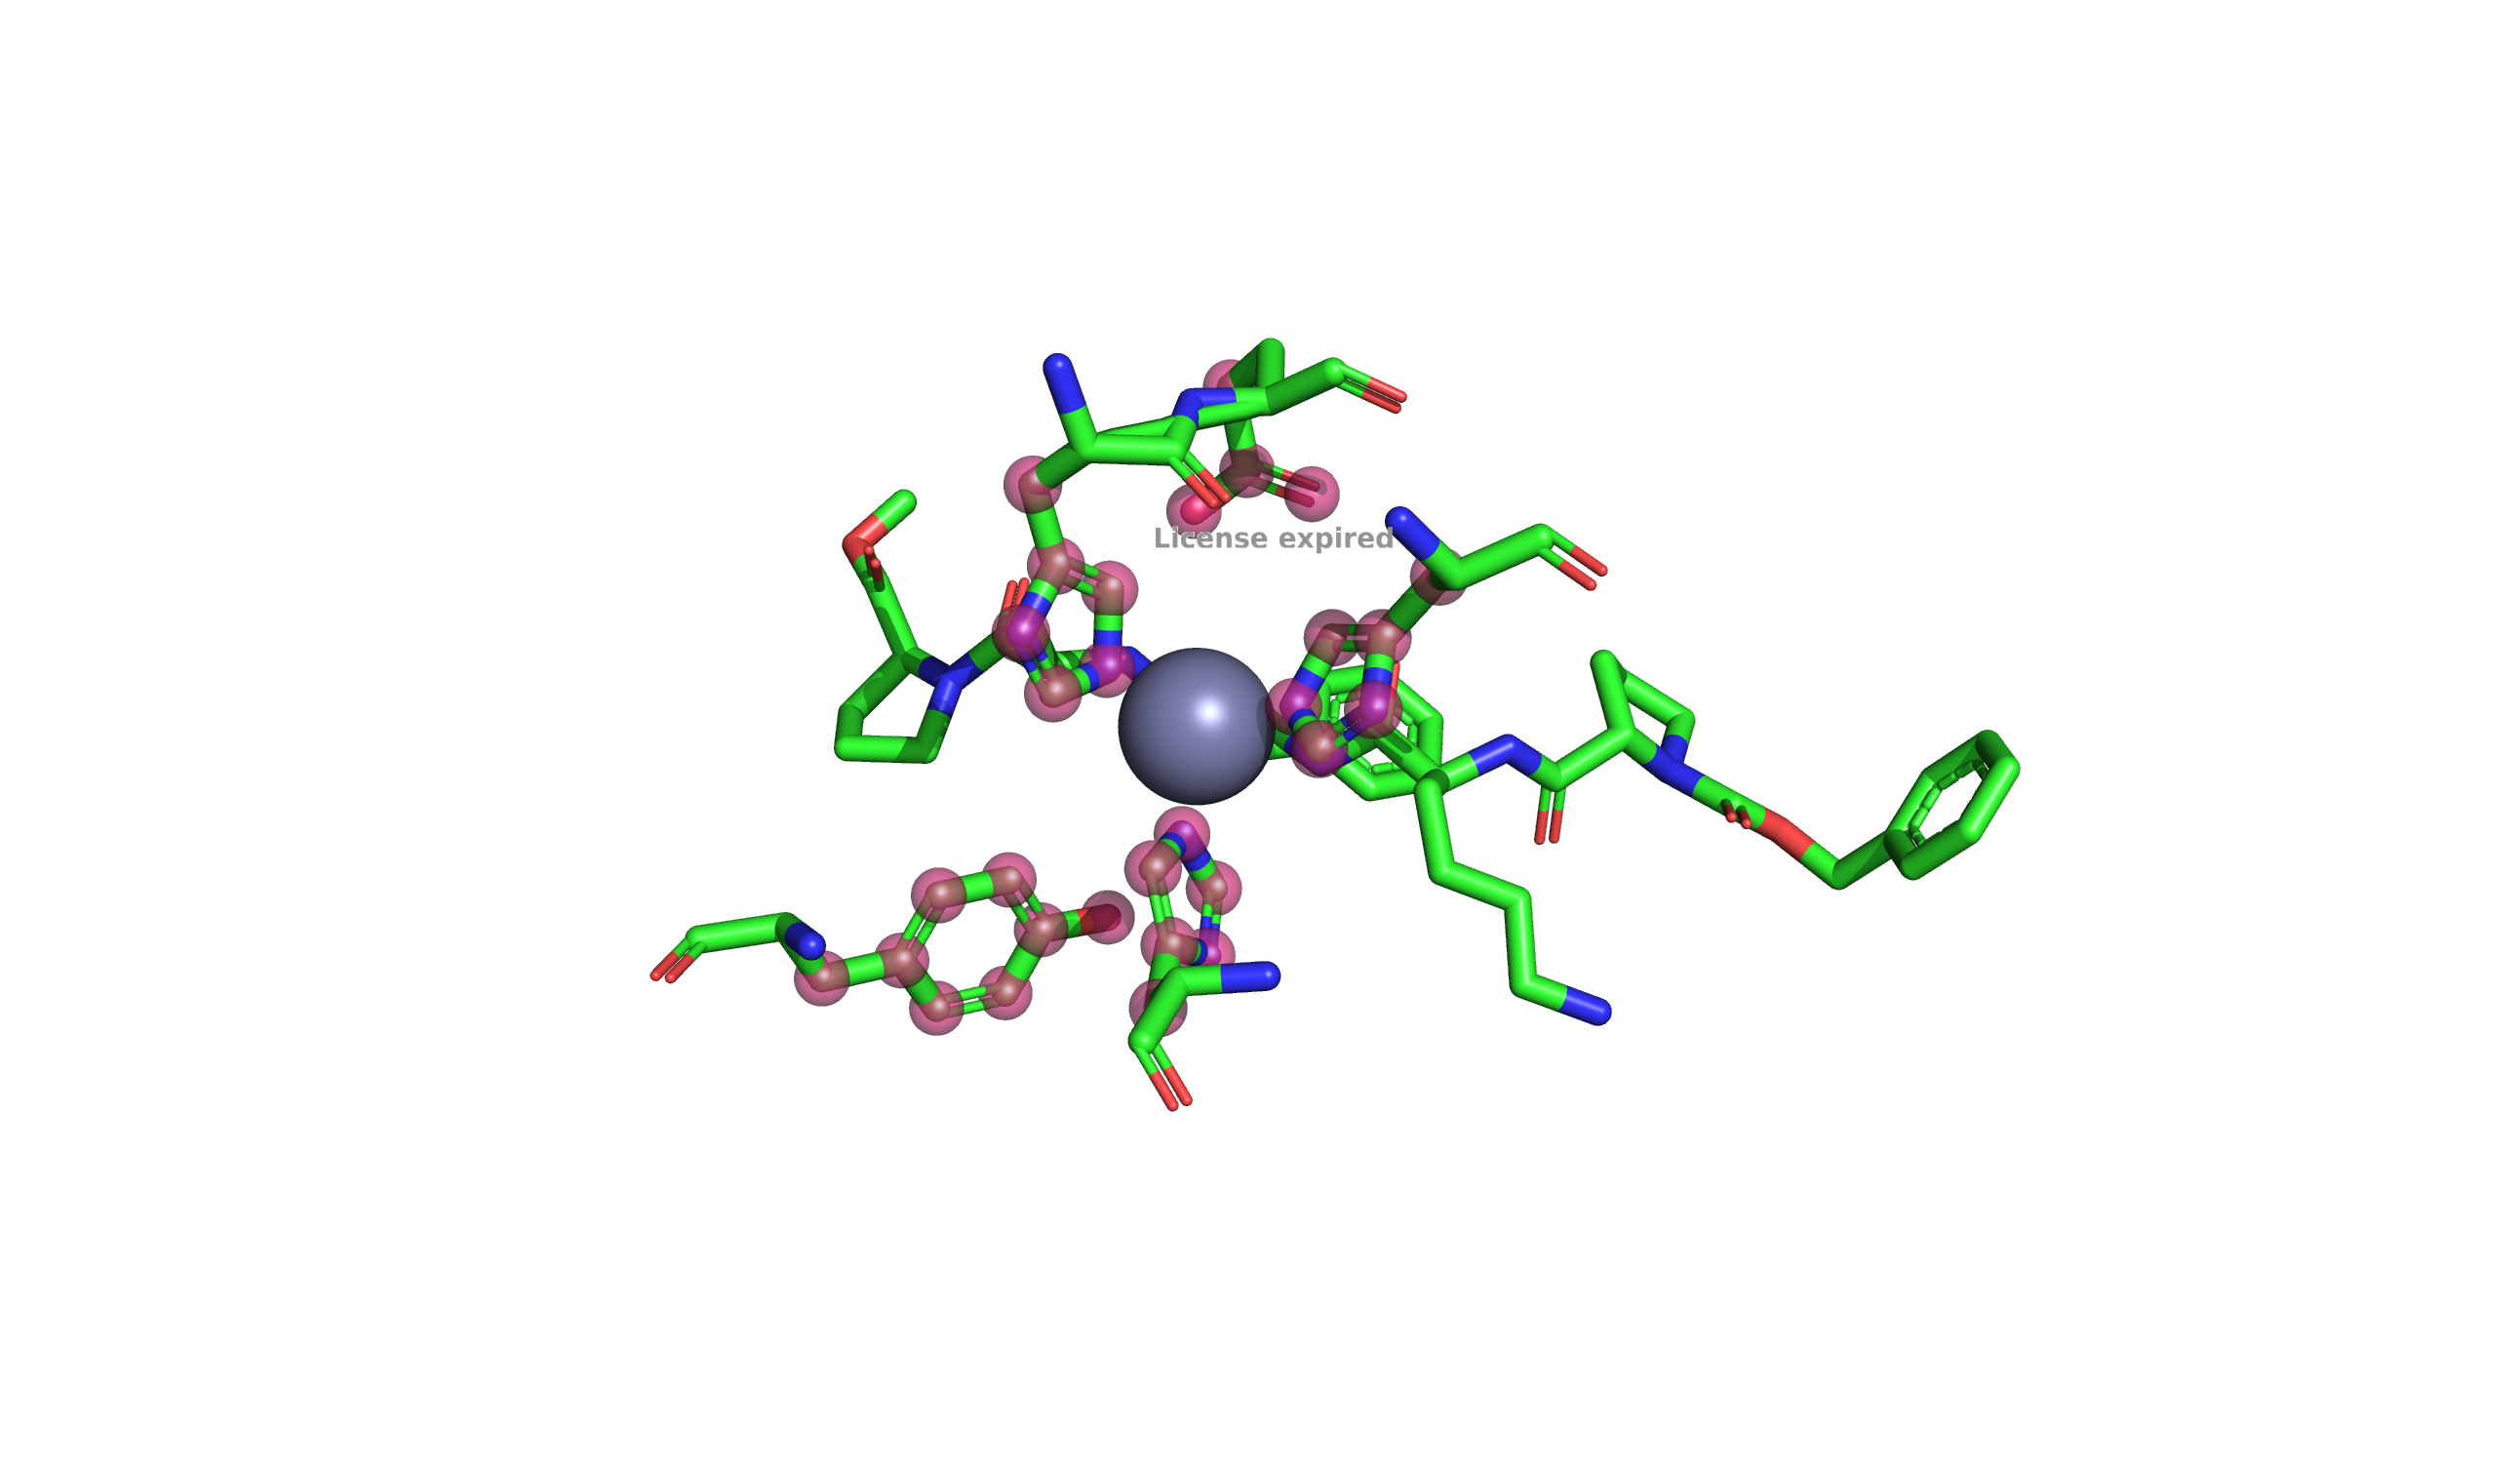

### **Why use just tip atoms as an input for RF diffusion?**
This puts less constraints on the problem

Allows greater diversity of backbones to be generated and conformational sampling of sidechains

Easier for RFD2 to "find" a solution (if designing completely *de novo*)

Now we will make the contig string and define a few parameters

In [18]:
############################################
### SET UP RFdiffusion2 (WITH ORI TOKEN) ###
############################################

### SET INPUT DIRECTORY (COMMON) ###
input_theozyme_motifs_DIR = f'{theozymes_dir}/original_ORI_tokens/' # need '/' at the end

### SET OUTPUT DIRECTORY FOR PRODUCED BACKBONES ###
rfd2_outdir = f'{output_dir}/rfd2_tutorial_run'
cmds_dir = f'{working_dir}/rfd2_cmds'
configs_dir = f'{output_dir}/configs'

Path(rfd2_outdir).mkdir(parents=True, exist_ok=True)
Path(cmds_dir).mkdir(parents=True, exist_ok=True)
Path(configs_dir).mkdir(parents=True, exist_ok=True)

common_additional_output_suffix='tutorial_t1'
### CONTIGS ###
length_range = "120-160"
### ESSENTIAL RF FLOW MATCHING PARAMETERS ###
nstruct = 5    # total outputs you want per topology

#########################################################################################################################
### ------------------- MOSTLY FIXED RFdiffusion2 PARAMETERS (SPECIFIED FOR NOTEKEEPING PURPOSES) ------------------- ###
#########################################################################################################################

### DEFAULTS ###
default = "aa"  # aa_v2 also works

### GUIDEPOST BONDS ###
guidepost_bonds = True

### INFERENCE FEATURES (POSSIBLE WIGGLE ROOM?) ###
timesteps = 50   # default is 100, but 50 should work just as well

write_trajectory = False # Boolean. Should the /traj/ video pdb file be generated? Takes up a lot of space in production
write_trb        = True  # Boolean. Should the .trb file be written?

align_motif                = False # aa = False | default = True
idealize_sidechain_outputs = True  # aa = True | default = False
guidepost_xyz_as_design    = True  # default = True

flexible_ligand = False  # default = False
center_motif    = True   # default = True

### INFERENCE FEATURES (MOSTLY FIXED) ###
contig_as_guidepost  = True   # default = False | probably need True for tip atom...
deterministic        = False

### **What is guideposting?**
Often, we won't know the ideal length of amino acids between contig residues, or where they should be in the sequence relative to each other.


Guideposting allows RFD2 to flexibly sample different lengths of backbone between your input residues, as well as the order of your residues in the sequence space.

This makes making the input much easier!

(I'm not a machine learning person and probably butchered this explanation)

Below we will set some more variables for running RFD2

In [20]:
### SET SCRIPT & CHECKPOINT ###
script     = f'{rfd2_dir}/rf_diffusion/run_inference.py'
checkpoint=f'{rfd2_dir}/rf_diffusion/model_weights/RFD_140.pt'

In [34]:
input_motif_with_residues = sorted(glob.glob(os.path.join(input_theozyme_motifs_DIR, '*.pdb')))
#For this example, we will just run RFD2 on one of the generated theozymes
input_pdb = input_motif_with_residues[0]
base_name = input_pdb.split('/')[-1].replace('.pdb','')
length_prefix = f'LENGTH_{length_range}'
output_prefix = f'{rfd2_outdir}/{base_name}_{length_prefix}_{common_additional_output_suffix}'
ligand = 'QA0'
contigs = [f'{length_range},{contig_residues}']  # <-- uses dynamic contig_residues


# III. Running RFD2

The function below generates .yaml files for input into RFD2

In [22]:
def make_config_file(config_file, checkpoint, num_designs,
                     input_pdb,
                     output_prefix,
                     ligand,
                     contigs,
                     contig_atoms_defs,
                     length_range,
                     write_trajectory=False,
                     write_trb=True,
                     radius=10,
                     default="aa",
                     contig_as_guidepost=True,
                     deterministic=False,
                     guidepost_bonds=True,
                     align_motif=False,
                     guidepost_xyz_as_design=True,
                     flexible_ligand=False,
                     idealize_sidechain_outputs=True,
                     center_motif=True,
                     ):
  with open(config_file, 'w') as config_f:
    config_txt = textwrap.dedent(f"""
    defaults:
      - {default}

    guidepost_bonds: {guidepost_bonds}

    inference:
      align_motif: {align_motif}
      ckpt_path: {checkpoint}
      num_designs: {num_designs}
      output_prefix: {output_prefix}
      input_pdb: {input_pdb}
      contig_as_guidepost: {contig_as_guidepost}
      guidepost_xyz_as_design: {guidepost_xyz_as_design}
      flexible_ligand: {flexible_ligand}
      deterministic: {deterministic}
      ligand: {ligand}
      idealize_sidechain_outputs: {idealize_sidechain_outputs}
      radius: {radius}
      write_trajectory: {write_trajectory}
      write_trb: {write_trb}
      center_motif: {center_motif}

    contigmap:
      contigs: {contigs}
      length: '{length_range}'
      contig_atoms: '{contig_atoms_defs}'

    diffuser:
      T: {timesteps}
  """)
    config_f.write(config_txt)

In [23]:

config_file_path = f'{configs_dir}/{base_name}_LENGTH_{length_range}_{common_additional_output_suffix}.yaml'
config = f'{base_name}_LENGTH_{length_range}_{common_additional_output_suffix}'
make_config_file(config_file_path, checkpoint, nstruct,
                 input_pdb,
                 output_prefix,
                 ligand,
                 contigs,
                 contig_atoms_defs,
                 length_range)

In [27]:
cmd = f'!/content/rfd2/bin/python {git_dir}/rf_diffusion/run_inference.py \
--config-dir={configs_dir} --config-name={config}'
print("copy and paste command below to run!")
print(cmd)

copy and paste command below to run!
!/content/rfd2/bin/python /content/drive/MyDrive/rfd2/rf_diffusion/run_inference.py --config-dir=/content/drive/MyDrive/enzdes_rfd2_tutorial/outputs/configs --config-name=1qji_theozyme_HEHHMY_ORI_01_LENGTH_120-160_tutorial_t1


In [26]:
!/content/rfd2/bin/python /content/drive/MyDrive/rfd2/rf_diffusion/run_inference.py --config-dir=/content/drive/MyDrive/enzdes_rfd2_tutorial/outputs/configs --config-name=1qji_theozyme_HEHHMY_ORI_01_LENGTH_120-160_tutorial_t1




/content/drive/MyDrive/rfd2/rf2aa/model/Track_module.py:356: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/content/drive/MyDrive/rfd2/rf2aa/model/Track_module.py:448: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/content/rfd2/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In '1qji_theozyme_HEHHMY_ORI_01_LENGTH_120-160_tutorial_t1': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
ic| model_runners.py:58 in load_model()
    self._conf.inference.ckpt_path: '/content/drive/MyDrive/rfd2/rf_diffusion/model_weights/RFD_140.pt'
[2025-11-05 13:15:15,247][rf_diffusion.config.config_format][INFO] - Translating ob

## Check out the designs that were generated

In [31]:
def show_pdb_simple(pdb_path):
  with open(pdb_path, 'r') as f:
    pdb_data = f.read()

    view = py3Dmol.view(width=600, height=400)
    view.addModel(pdb_data, 'pdb')
    view.setStyle({'cartoon': {'color': 'spectrum'}})
    view.addStyle({'and': [
    {'resn': ['ALA','VAL','LEU','ILE','PHE','TYR','TRP','SER','THR','ASN','GLN','ASP','GLU','LYS','ARG','HIS','CYS','MET','PRO','GLY']}
]}, {'stick': {}})

# Sticks for ligands (anything that’s not a standard residue)
    view.addStyle({'hetflag': True}, {'stick': {'colorscheme': 'greenCarbon'}})
    view.addStyle({'atom': 'ZN'}, {'sphere': {'color': 'silver', 'radius': 1.0}})

    view.zoomTo()
    view.show()

In [33]:
pdbs = glob.glob(f'{output_prefix}*pdb')
for pdb in pdbs:
  show_pdb_simple(pdb)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.